In [1]:
from collections import Counter
import wfdb
from wfdb import processing
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow as tf
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [14]:
####################     Defining network function     ####################
tf.logging.set_verbosity(tf.logging.INFO)

def cnn_model_fn(features, labels, mode):
    input_layer = tf.reshape(features["x"], [-1, 256, 1])

  # Convolutional Layer and Pooling Layer #1
    conv1 = tf.layers.conv1d(
      inputs = input_layer,
      filters = 64,
      kernel_size = 16,
      padding = "same",
      activation = tf.nn.relu)
    pool1 = tf.layers.max_pooling1d(inputs = conv1, pool_size= 2, strides = 2)

  # Convolutional Layer and Pooling Layer #2
    conv2 = tf.layers.conv1d(
      inputs = pool1,
      filters = 128,
      kernel_size = 8,
      padding = "same",
      activation = tf.nn.relu)
    pool2 = tf.layers.max_pooling1d(inputs = conv2, pool_size = 2, strides = 2)

  # Convolutional Layer and Pooling Layer #3
    conv3 = tf.layers.conv1d(
      inputs = pool2,
      filters = 256,
      kernel_size = 4,
      padding = "same",
      activation = tf.nn.relu)
    pool3 = tf.layers.max_pooling1d(inputs = conv3, pool_size = 2, strides = 2)
  
  # Convolutional Layer and Pooling Layer #4
    conv4 = tf.layers.conv1d(
      inputs = pool3,
      filters = 512,
      kernel_size = 2,
      padding = "same",
      activation = tf.nn.relu)
    pool4 = tf.layers.max_pooling1d(inputs = conv4, pool_size = 2, strides = 2)
   
  # Fully Connected Layer #1
    pool3_flat = tf.reshape(pool4, [-1, 16 * 512]);
    dense1 = tf.layers.dense(inputs = pool3_flat, units = 1024, activation = tf.nn.relu); 
    dropout = tf.layers.dropout(inputs = dense1, rate = 0.5, training = mode == tf.estimator.ModeKeys.TRAIN);

  # Logits Layer
    logits = tf.layers.dense(inputs = dropout, units = 5);

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input = logits, axis = 1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name = "softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions);

    # Calculate Loss (for both TRAIN and EVAL modes)
    # deduce weights for batch samples based on their true label
    Weights = [0.5, 0.75, 3, 30, 1];
    Class_Weights = tf.constant(Weights);
    Weights_tf = tf.gather(Class_Weights, labels);
    loss = tf.losses.sparse_softmax_cross_entropy(labels = labels, logits = logits, weights = Weights_tf);

  # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
        train_op = optimizer.minimize(
        loss = loss,
        global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode = mode, loss = loss, train_op = train_op)

  # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {"accuracy": tf.metrics.accuracy(labels = labels, predictions = predictions["classes"])};
    return tf.estimator.EstimatorSpec(mode = mode, loss = loss, eval_metric_ops = eval_metric_ops);


#if __name__ == "__main__":
#    tf.app.run()

In [3]:
####################     Loading training and testing data     ####################
def peaks(x, peak_indices, fs):
    hrs = wfdb.processing.compute_hr(x.shape[0], peak_indices, fs);
    return hrs;

#Single beats extraction for record
def extract_beats(record, R_indices, peaks_hr, freq):
    
    flat_record = [item for sublist in record for item in sublist];
    ecg_beats = [];
    
    #Extract beats of different lengths depending on heart rate
    for i in range(0, len(R_indices)):
        hr = peaks_hr[R_indices[i]].item();
        if(math.isnan(hr)):
            hr = 70.0;
        samples_per_beat = int(freq*(60.0/hr))
        start = R_indices[i]-int(samples_per_beat/2);
        if(start<0):
            start = 0;
        end = start + samples_per_beat;
        ecg_beats.append(np.array(flat_record[start:end]));
    
    #Resample beats to get fixed input size for classification
    ecg_nparray = np.empty((len(ecg_beats), 256));
    for i in range(0,len(ecg_beats)):    
        ecg_beats[i], _ = wfdb.processing.resample_sig(x=ecg_beats[i],fs=len(ecg_beats[i]), fs_target=256);
        ecg_nparray[i] = ecg_beats[i];
            
    return ecg_nparray;

#Reads a single record and its annotation file
def read_record(rec):
    # Load the wfdb record and the physical samples
    print("Reading record: " + rec);
    record = wfdb.rdrecord('./dataset/'+rec, channels=[0], return_res = 32);
    annotation = wfdb.rdann('./dataset/'+rec, 'atr', summarize_labels=True);
    freq = record.fs;
    sig = record.p_signal;
    sig = wfdb.processing.normalize_bound(sig, lb=0, ub=1);

    for idx, val in enumerate(sig):    
        record.p_signal[idx,0] = val;

    peak_indices = annotation.sample;
    peaks_hr = peaks(x=record.p_signal, peak_indices=peak_indices, fs=record.fs);
    ecg_beats = extract_beats(record.p_signal, peak_indices, peaks_hr,freq);
    
    return ecg_beats, annotation;

#Reads a list of records and their annotations
def read_records(records):
    beats = [];
    annotations = [];
    for i, rec in enumerate(records):
        rec_beats , annotation = read_record(str(rec));
        beats.append(rec_beats);
        annotations.append(annotation.symbol);
    flat_beats = [item for sublist in beats for item in sublist]
    flat_ann = [item for sublist in annotations for item in sublist]
    return flat_beats, flat_ann;
 
#Used to remove unwanted classes   
def clean_records(beats,anns):
    clean_anns = [];
    clean_beats = [];
    for i, ann in enumerate(anns):
        if(ann==0 or ann==1 or ann==2 or ann==3 or ann==4):
            clean_beats.append(beats[i]);
            clean_anns.append(anns[i]);
    return clean_beats,clean_anns;
    

train_records = [101,106,108,109,112,114,115,116,118,119,122,124,201,203,205,207,208,209,215,220,223,230];
test_records = [100,103,105,111,113,117,121,123,200,202,210,212,213,214,219,221,222,228,231,232,233,234];

print("Reading training data")
flat_beats_train, flat_ann_train = read_records(train_records);
print("\nReading testing data")
flat_beats_test, flat_ann_test = read_records(test_records);


Ann_Dict = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4, 'A': 5, '+': 6, 'f': 7, 'R': 8, '~': 9, '!': 10, '"': 11,
            'j': 12, 'x': 13, 'a': 14, '|': 15, 'E': 16, 'J': 17, '/': 18, 'e': 19, ']': 20, '[': 21, 'L': 22
            };

flat_labels_train = [];
for text_label in flat_ann_train:
    flat_labels_train.append(Ann_Dict[text_label]);

flat_labels_test = [];
for text_label in flat_ann_test:
    flat_labels_test.append(Ann_Dict[text_label]);

flat_beats_train, flat_labels_train = clean_records(flat_beats_train, flat_labels_train);
flat_beats_test, flat_labels_test = clean_records(flat_beats_test, flat_labels_test);

np_flat_beats_train = np.asarray(flat_beats_train, dtype = np.float32);
np_labels_train = np.asarray(flat_labels_train, dtype = np.int32);
np_flat_beats_test = np.asarray(flat_beats_test, dtype = np.float32);
np_labels_test = np.asarray(flat_labels_test, dtype = np.int32);

print("Finished reading records.");

Reading training data
Reading record: 101
Reading record: 106
Reading record: 108
Reading record: 109
Reading record: 112
Reading record: 114
Reading record: 115
Reading record: 116
Reading record: 118
Reading record: 119
Reading record: 122
Reading record: 124
Reading record: 201
Reading record: 203
Reading record: 205
Reading record: 207
Reading record: 208
Reading record: 209
Reading record: 215
Reading record: 220
Reading record: 223
Reading record: 230

Reading testing data
Reading record: 100
Reading record: 103
Reading record: 105
Reading record: 111
Reading record: 113
Reading record: 117
Reading record: 121
Reading record: 123
Reading record: 200
Reading record: 202
Reading record: 210
Reading record: 212
Reading record: 213
Reading record: 214
Reading record: 219
Reading record: 221
Reading record: 222
Reading record: 228
Reading record: 231
Reading record: 232
Reading record: 233
Reading record: 234
Finished reading records.


In [4]:
####################     Calculating class frequencies/weights     ####################
weights = [];
Ann_Counter = Counter(flat_labels_train);
print(Ann_Counter)
print(Counter(flat_labels_test))
total_beats_count = len(flat_beats_train);
for value in Ann_Counter.values():
    weights.append(value/total_beats_count);    
weights.sort(reverse = True);
inverse_Weights = [ 1 / i for i in weights];
norm = [ ( float(i * 1000) / sum(inverse_Weights) +.25) for i in inverse_Weights]
print("Sum: " + str(sum(norm)))
print("Weights: " + str(norm));

Counter({0: 38102, 2: 3683, 3: 415, 4: 8, 1: 2})
Counter({0: 36444, 2: 3220, 3: 388, 4: 7})
Sum: 1001.25
Weights: [0.2918114258038787, 0.682554696166002, 4.088792640914182, 199.38736824742318, 796.7994729896927]


In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_num_ps_replicas': 0, '_num_worker_replicas': 1, '_is_chief': True, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_master': '', '_service': None, '_save_checkpoints_steps': None, '_save_summary_steps': 100, '_task_type': 'worker', '_tf_random_seed': None, '_session_config': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000164C2BFAC50>, '_evaluation_master': '', '_train_distribute': None, '_model_dir': '/tmp/MIT_BIH_convnet_model54', '_global_id_in_cluster': 0, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/MIT_BIH_convnet_model54\model.ckpt-79145
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

INFO:tensorflow:loss = 0.9021976, step = 84145 (1.260 sec)
INFO:tensorflow:global_step/sec: 79.2475
INFO:tensorflow:loss = 0.09734834, step = 84245 (1.259 sec)
INFO:tensorflow:global_step/sec: 79.62
INFO:tensorflow:loss = 0.2862853, step = 84345 (1.257 sec)
INFO:tensorflow:global_step/sec: 80.2316
INFO:tensorflow:loss = 0.4350438, step = 84445 (1.245 sec)
INFO:tensorflow:global_step/sec: 80.0574
INFO:tensorflow:loss = 0.032793228, step = 84545 (1.250 sec)
INFO:tensorflow:global_step/sec: 80.0023
INFO:tensorflow:loss = 0.00636615, step = 84645 (1.249 sec)
INFO:tensorflow:global_step/sec: 79.9921
INFO:tensorflow:loss = 0.16514163, step = 84745 (1.250 sec)
INFO:tensorflow:global_step/sec: 79.5925
INFO:tensorflow:loss = 0.41783708, step = 84845 (1.257 sec)
INFO:tensorflow:global_step/sec: 80.0906
INFO:tensorflow:loss = 0.06185057, step = 84945 (1.248 sec)
INFO:tensorflow:global_step/sec: 79.7059
INFO:tensorflow:loss = 0.014394068, step = 85045 (1.256 sec)
INFO:tensorflow:global_step/sec: 8

INFO:tensorflow:global_step/sec: 79.5763
INFO:tensorflow:loss = 0.00054461893, step = 90445 (1.257 sec)
INFO:tensorflow:global_step/sec: 79.9228
INFO:tensorflow:loss = 2.8050773, step = 90545 (1.250 sec)
INFO:tensorflow:global_step/sec: 79.294
INFO:tensorflow:loss = 1.5411963, step = 90645 (1.262 sec)
INFO:tensorflow:global_step/sec: 79.4951
INFO:tensorflow:loss = 1.5241051, step = 90745 (1.258 sec)
INFO:tensorflow:global_step/sec: 79.518
INFO:tensorflow:loss = 0.035947002, step = 90845 (1.258 sec)
INFO:tensorflow:global_step/sec: 80.002
INFO:tensorflow:loss = 0.0040438054, step = 90945 (1.250 sec)
INFO:tensorflow:global_step/sec: 79.1398
INFO:tensorflow:loss = 0.1815533, step = 91045 (1.264 sec)
INFO:tensorflow:global_step/sec: 80.1458
INFO:tensorflow:loss = 0.11471315, step = 91145 (1.248 sec)
INFO:tensorflow:global_step/sec: 79.7704
INFO:tensorflow:loss = 0.09092841, step = 91245 (1.262 sec)
INFO:tensorflow:global_step/sec: 78.3408
INFO:tensorflow:loss = 0.059813652, step = 91345 (1

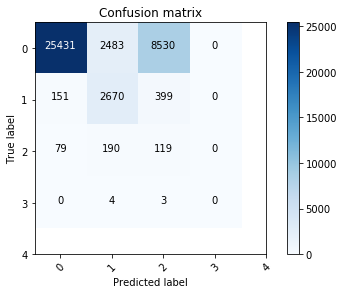

In [17]:
####################     Classification     ####################
classifier_ = tf.estimator.Estimator(model_fn = cnn_model_fn, model_dir = "/Models/MIT_BIH_convnet_model")

tensors_to_log = {"probabilities": "softmax_tensor"};
logging_hook = tf.train.LoggingTensorHook(tensors = tensors_to_log, every_n_iter = 5000);
    
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {"x": np_flat_beats_train},
    y = np_labels_train,
    batch_size = 32,
    num_epochs = 80,
    shuffle = True);
classifier_.train(input_fn = train_input_fn, hooks = [logging_hook]);

eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {"x": np_flat_beats_train},
    y = np_labels_train,
    num_epochs = 1,
    shuffle = False);
eval_results = classifier_.evaluate(input_fn = eval_input_fn);

eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {"x": np_flat_beats_test},
    y = np_labels_test,
    num_epochs = 1,
    shuffle = False);
eval_results = classifier_.evaluate(input_fn = eval_input_fn);

predictions = list(classifier_.predict(input_fn = eval_input_fn));
class_predictions = [tmp.get("classes") for tmp in predictions];

conf_mat = confusion_matrix(flat_labels_test, class_predictions);
print(conf_mat);


plt.figure();
plot_confusion_matrix(conf_mat, classes = [0, 1, 2, 3, 4], title='Confusion matrix');
plt.show();
